# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 6 — Source Separation

---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember

In [1]:
import functools

import jax
import jax.numpy as jnp
import numpy as np


jax.config.update("jax_enable_x64", True)

In [2]:
from matplotlib import pyplot as plt
from tueplots import bundles
from tueplots.constants.color import rgb


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

## Exercise 6.2 (Coding Exercise)

The lecture covered an extended example, in which a GP was used to model the Keeling curve, i.e. the temporal evolution of the atmospheric $\text{CO}_2$ concentration at Mauna Loa Observatory in Hawaii.
This model is useful for separating certain effects in the data like long- and mid-term trends as well as periodicity.

However, since all kernels used for modelling the data are in fact so-called stationary (or translation-invariant) kernels, i.e. $k(t_0, t_1) = k(\lvert t_0 - t_1 \rvert)$, the model will not extrapolate well.
Rather, its prediction will at some point return to the prior mean, which is just set to a constant.

In this exercise, we will attempt to fix this problem by injecting more prior knowledge into the model.
Specifically, we will add a covariate, which we hypothesize to have causal influence on the atmospheric $\text{CO}_2$ concentration.
By scrutinizing the behavior of the model on the dataset, we can gain insights into the predictive power of the covariate.

**Disclaimer:** This is a very crude data analysis, which is merely meant to illustrate how GPs can be augmented with additional input data. It should not be used to make any scientific statement about the dynamics of atmospheric $\text{CO}_2$ concentration.

### Data

First, let's load and plot the data.

In [3]:
data = np.load("Ex06_data.npz")

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


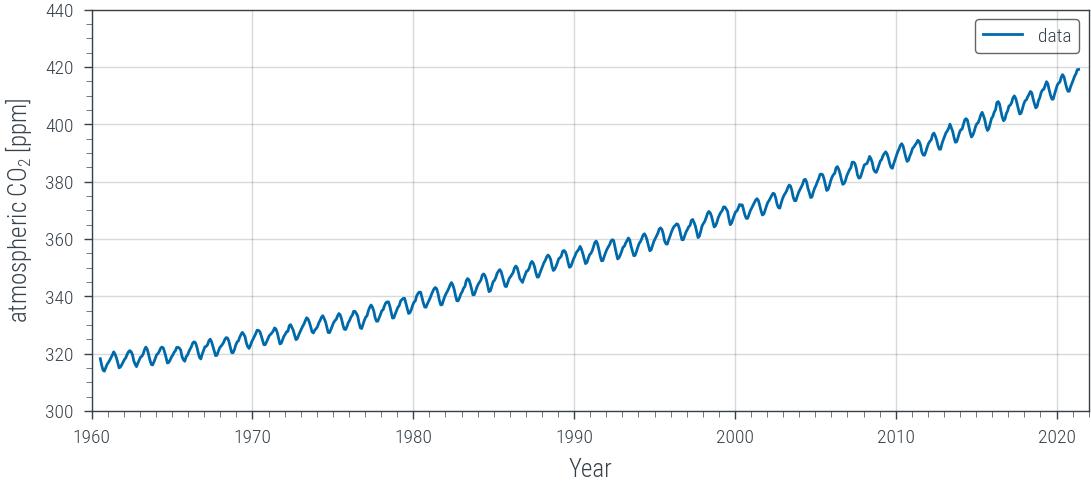

In [4]:
from matplotlib import ticker


def setup_plot(ax):
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim([1960, 2022])
    ax.grid(which="major", axis="both")


def plot_data(ax):
    ax.plot(
        data["date"],
        data["atmospheric_co2"],
        label="data",
        color=rgb.tue_blue,
    )
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_ylabel("atmospheric CO$_2$ [ppm]")
    ax.set_ylim([300, 440])


setup_plot(plt.gca())
plot_data(plt.gca())

plt.legend()

We will work under the hypothesis that the total [gross domestic product](https://en.wikipedia.org/wiki/Gross_domestic_product) (GDP) of the world economy has a causal effect on the atmospheric CO2 concentration.

The `data["world_gdp"]` array contains estimates of the world GDP over time. The raw data is made available by the [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD) and has been linearly interpolated to match the temporal resolution of the atmospheric $\text{CO}_2$ data.

Text(0, 0.5, 'World GDP [$]')

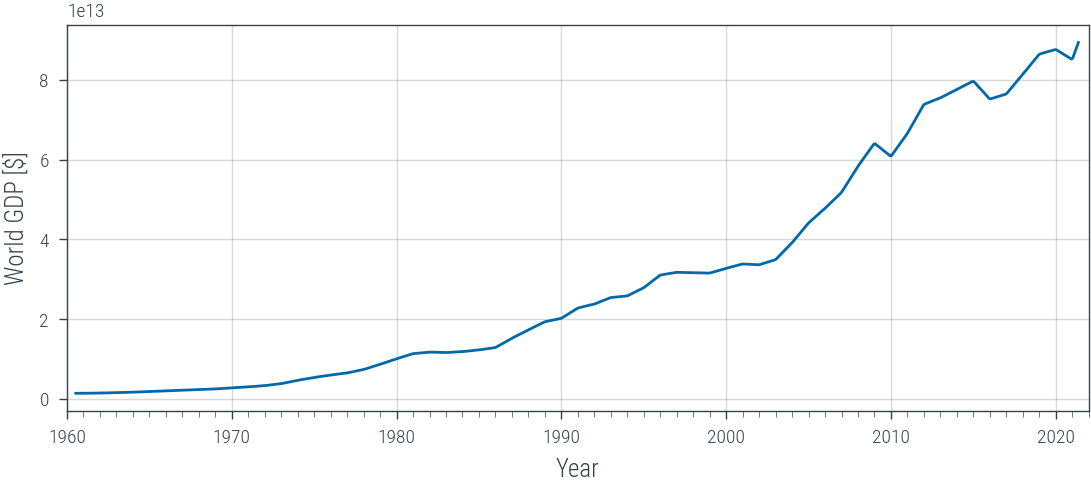

In [5]:
setup_plot(plt.gca())

plt.plot(
    data["date"],
    data["world_gdp"],
    label="World GDP",
    color=rgb.tue_blue,
)

plt.ylabel("World GDP [$]")

Comparing the plots of the atmospheric $\text{CO}_2$ concentration and the world GDP over time, there seems to be a relationship between the two.

To emphasize this, we plot the two against one another.

Text(0, 0.5, 'atmospheric CO$_2$ [ppm]')

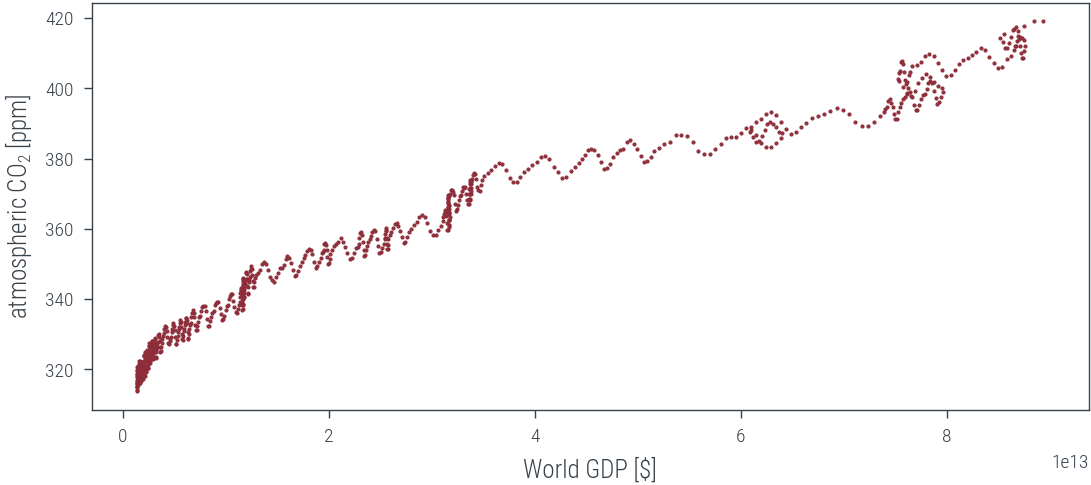

In [6]:
plt.plot(
    data["world_gdp"],
    data["atmospheric_co2"],
    ".",
    markersize=1,
)

plt.xlabel("World GDP [$]")
plt.ylabel("atmospheric CO$_2$ [ppm]")

This plot suggests that a globally linear relationship between the world GDP and the atmospheric $\text{CO}_2$ concentration with some local deviations might explain the data reasonably well.

### Building a Prior

We will now build a non-stationary GP prior $f$ for explaining this phenomenon.

In [7]:
import dataclasses
from collections.abc import Callable


@dataclasses.dataclass
class Gaussian:
    # Gaussian distribution with mean mu and covariance Sigma
    mu: jnp.ndarray  # shape (D,)
    Sigma: jnp.ndarray  # shape (D,D)

    @functools.cached_property
    def L(self):
        """Cholesky decomposition of the covariance matrix"""
        return jnp.linalg.cholesky(self.Sigma)

    @functools.cached_property
    def L_factor(self):
        """Cholesky factorization of the covariance matrix
        (for use in jax.scipy.linalg.cho_solve)"""
        return jax.scipy.linalg.cho_factor(self.Sigma, lower=True)

    @functools.cached_property
    def logdet(self):
        """log-determinant of the covariance matrix
        e.g. for computing the log-pdf
        """
        return 2 * jnp.sum(jnp.log(jnp.diag(self.L)))

    @functools.cached_property
    def prec(self):
        """precision matrix.
        you probably don't want to use this directly, but rather prec_mult
        """
        return jnp.linalg.inv(self.Sigma)

    def prec_mult(self, x):
        """precision matrix multiplication
        implements Sigma^{-1} @ x. For numerical stability, we use the Cholesky factorization
        """
        return jax.scipy.linalg.cho_solve(self.L_factor, x)

    @functools.cached_property
    def mp(self):
        """precision-adjusted mean"""
        return self.prec_mult(self.mu)

    def log_pdf(self, x):
        """log N(x;mu,Sigma)"""
        return (
            -0.5 * (x - self.mu) @ self.prec_mult(x - self.mu)
            - 0.5 * self.logdet
            - 0.5 * len(self.mu) * jnp.log(2 * jnp.pi)
        )

    def __mult__(self, other):
        """
        Products of Gaussian pdfs are Gaussian pdfs!
        Multiplication of two Gaussian PDFs  (not RVs!)
        other: Gaussian RV
        """
        Sigma = jnp.linalg.inv(self.prec + other.prec)
        mu = Sigma @ (self.mp + other.mp)
        return Gaussian(mu=mu, Sigma=Sigma)

    def __rmatmul__(self, A):
        """Linear maps of Gaussian RVs are Gaussian RVs
        A: linear map, shape (N,D)
        """
        return Gaussian(mu=A @ self.mu, Sigma=A @ self.Sigma @ A.T)

    @functools.singledispatchmethod
    def __add__(self, other):
        """Affine maps of Gaussian RVs are Gaussian RVs
        shift of a Gaussian RV by a constant.
        We implement this as a singledispatchmethod, because jnp.ndarrays can not be dispatched on,
        and register the addition of two RVs below
        """
        other = jnp.asarray(other)
        return Gaussian(mu=self.mu + other, Sigma=self.Sigma)

    def condition(self, A, y, Lambda):
        """Linear conditionals of Gaussian RVs are Gaussian RVs
        Conditioning of a Gaussian RV on a linear observation
        A: observation matrix, shape (N,D)
        y: observation, shape (N,)
        Lambda: observation noise covariance, shape (N,N)
        """
        Gram = A @ self.Sigma @ A.T + Lambda
        L = jax.scipy.linalg.cho_factor(Gram, lower=True)
        mu = self.mu + self.Sigma @ A.T @ jax.scipy.linalg.cho_solve(L, y - A @ self.mu)
        Sigma = self.Sigma - self.Sigma @ A.T @ jax.scipy.linalg.cho_solve(
            L, A @ self.Sigma
        )
        return Gaussian(mu=mu, Sigma=Sigma)

    @functools.cached_property
    def std(self):
        # standard deviation
        return jnp.sqrt(jnp.diag(self.Sigma))

    def sample(self, key, num_samples=1):
        """
         sample from the Gaussian
        # alternative implementation: works because the @ operator contracts on the second-to-last axis on the right
        # return (self.L @ jax.random.normal(key, shape=(num_samples, self.mu.shape[0], 1)))[...,0] + self.mu
        # or like this, more explicit, but not as easy to read
        # return jnp.einsum("ij,kj->ki", self.L, jax.random.normal(key, shape=(num_samples, self.mu.shape[0]))) + self.mu
        # or the scipy version:
        """
        return jax.random.multivariate_normal(
            key, mean=self.mu, cov=self.Sigma, shape=(num_samples,), method="svd"
        )


@Gaussian.__add__.register
def _add_gaussians(self, other: Gaussian):
    # sum of two Gaussian RVs
    return Gaussian(mu=self.mu + other.mu, Sigma=self.Sigma + other.Sigma)


@dataclasses.dataclass
class GaussianProcess:
    # mean function
    m: Callable[[jnp.ndarray], jnp.ndarray]
    # covariance function
    k: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]

    def __call__(self, x):
        return Gaussian(mu=self.m(x), Sigma=self.k(x[:, None, :], x[None, :, :]))

    def condition(self, y, X, sigma):
        return ConditionalGaussianProcess(
            self, y, X, Gaussian(mu=jnp.zeros_like(y), Sigma=sigma * jnp.eye(len(y)))
        )

    def plot(
        self,
        ax,
        x,
        color=rgb.tue_gray,
        mean_kwargs={},
        std_kwargs={},
        num_samples=0,
        rng_key=None,
    ):
        gp_x = self(x)
        ax.plot(x[:, 0], gp_x.mu, color=color, **mean_kwargs)
        ax.fill_between(
            x[:, 0],
            gp_x.mu - 2 * gp_x.std,
            gp_x.mu + 2 * gp_x.std,
            color=color,
            **std_kwargs
        )
        if num_samples > 0:
            ax.plot(
                x[:, 0],
                gp_x.sample(rng_key, num_samples=num_samples).T,
                color=color,
                alpha=0.2,
            )

    def plot_shaded(
        self,
        ax,
        x,
        color=rgb.tue_gray,
        yrange=None,
        yres=1000,
        mean_kwargs={},
        std_kwargs={},
        num_samples=0,
        rng_key=None,
    ):
        if yrange is None:
            yrange = ax.get_ylim()

        gp_x = self(x)
        ax.plot(x[:, 0], gp_x.mu, color=color, **mean_kwargs)

        yy = jnp.linspace(*yrange, yres)[:, None]
        ax.imshow(
            gp_shading(yy, gp_x.mu, gp_x.std),
            extent=[x[0, 0], x[-1, 0], *yrange],
            **std_kwargs,
            aspect="auto",
            origin="lower"
        )

        ax.plot(x[:, 0], gp_x.mu - 2 * gp_x.std, color=color, lw=0.25)
        ax.plot(x[:, 0], gp_x.mu + 2 * gp_x.std, color=color, lw=0.25)
        if num_samples > 0:
            ax.plot(
                x[:, 0],
                gp_x.sample(rng_key, num_samples=num_samples).T,
                color=color,
                alpha=0.2,
            )

def gp_shading(yy, mu, std):
        return jnp.exp(-((yy - mu) ** 2) / (2 * std**2)) # / (std * jnp.sqrt(2 * jnp.pi))

class ConditionalGaussianProcess(GaussianProcess):
    """
    A Gaussian process conditioned on data.
    Implented as a proper python class, which allows inheritance from the GaussianProcess superclass:
    A conditional Gaussian process contains a Gaussian process prior, provided at instantiation.
    """

    def __init__(self, prior, y, X, epsilon: Gaussian):
        self.prior = prior
        self.y = jnp.atleast_1d(y)  # shape: (n_samples,)
        self.X = jnp.atleast_2d(X)  # shape: (n_samples, n_features)
        self.epsilon = epsilon
        # initialize the super class
        super().__init__(self._mean, self._covariance)

    @functools.cached_property
    def predictive_covariance(self):
        return self.prior.k(self.X[:, None, :], self.X[None, :, :]) + self.epsilon.Sigma

    @functools.cached_property
    def predictive_mean(self):
        return self.prior.m(self.X) + self.epsilon.mu

    @functools.cached_property
    def predictive_covariance_cho(self):
        return jax.scipy.linalg.cho_factor(self.predictive_covariance)

    @functools.cached_property
    def representer_weights(self):
        return jax.scipy.linalg.cho_solve(
            self.predictive_covariance_cho,
            self.y - self.predictive_mean,
        )

    def _mean(self, x):
        x = jnp.asarray(x)
        return (
            self.prior.m(x)
            + self.prior.k(x[..., None, :], self.X[None, :, :])
            @ self.representer_weights
        )

    @functools.partial(jnp.vectorize, signature="(d),(d)->()", excluded={0})
    def _covariance(self, a, b):
        return self.prior.k(a, b) - self.prior.k(
            a, self.X
        ) @ jax.scipy.linalg.cho_solve(
            self.predictive_covariance_cho,
            self.prior.k(self.X, b),
        )

    def _m_proj(self, x, projection, projection_mean):
        x = jnp.asarray(x)

        if projection_mean is None:
            projection_mean = self.prior.m

        return (
            projection_mean(x)
            + projection(x[..., None, :], self.X[None, :, :]) @ self.representer_weights
        )

    @functools.partial(jnp.vectorize, signature="(d),(d)->()", excluded={0, 3})
    def _cov_proj(self, a, b, projection):
        return projection(a, b) - projection(a, self.X) @ jax.scipy.linalg.cho_solve(
            self.predictive_covariance_cho,
            projection(b, self.X),
        )

    def project(self, k_proj, m_proj=None):
        return GaussianProcess(
            lambda x: self._m_proj(x, k_proj, m_proj),
            lambda x0, x1: self._cov_proj(x0, x1, k_proj),
        )

In [19]:
# Let's define some commonly used building blocks for GP models
def zero_mean(x):
    return jnp.zeros_like(x[..., 0])

def gaussian_kernel(x0, x1, ell=1.0, theta=1.0):
    return theta**2 * jnp.exp(-jnp.sum((x0 - x1)**2, axis=-1) / (2. * ell**2))

def rational_quadratic_kernel(x0, x1, alpha=1.0, ell=1.0, theta=1.0):
    return theta**2 * (
        1 + jnp.sum((x0 - x1) ** 2, axis=-1) / (2 * alpha * ell**2)
    ) ** (-alpha)

def matern_1_2_kernel(x0, x1, ell=1.0, theta=1.0):
    return theta**2 * jnp.exp(
        -jnp.linalg.norm(x0 - x1, 2, axis=-1) / ell
    )

In [9]:
from matplotlib.colors import LinearSegmentedColormap

cmap_rw = LinearSegmentedColormap.from_list(
    "rw", [(1, 1, 1), rgb.tue_red], N=1024)
cmap_dw = LinearSegmentedColormap.from_list(
    "dw", [(1, 1, 1), rgb.tue_dark], N=1024)
cmap_bw = LinearSegmentedColormap.from_list(
    "bw", [(1, 1, 1), rgb.tue_blue], N=1024)
cmap_gw = LinearSegmentedColormap.from_list(
    "gw", [(1, 1, 1), rgb.tue_green], N=1024)
cmap_bwr = LinearSegmentedColormap.from_list(
    "bwr", [rgb.tue_blue, (1, 1, 1), rgb.tue_red], N=1024
)

Our prior will be a modification of the model from the lecture, which replaces the long-term trend by a GDP-based additive component.
To inform the GP about the current value of the GDP, we will construct a bivariate model with inputs
\begin{equation}
    f(t, \text{GDP}(t)).
\end{equation}
This way, we can still interpret our GP as a univariate function of time if we know the (approximate) GPD at every evaluation point $t$.

In [10]:
X = jnp.stack(
    (data["date"], data["world_gdp"]),
    axis=-1,
)
y = jnp.asarray(data["atmospheric_co2"])

X_train = X[:-200, :]
y_train = y[:-200]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
def decompose_t_gdp(t_gdp):
    """This function will come in handy when implementing mean functions and kernels for the GP."""
    t_gdp = jnp.asarray(t_gdp)
    return t_gdp[..., 0], t_gdp[..., 1]

Like the model in the lecture, our GP prior will be an additive combination of simpler GP priors with different responsibilities:

\begin{equation}
    f(t, \text{GDP}(t)) = f_\text{const}(t) + f_\text{GDP}(t, \text{GDP}(t)) + f_\text{period}(t) + f_\text{mid-term}(t) + f_\text{weather}(t).
\end{equation}

First, we extend the model from the lecture by allowing the GP to learn the constant component $f_\text{const}$ of the posterior.
We can achieve this this by constructing a parametric GP with one constant feature function $\phi(t) = 1$, i.e.
\begin{equation}
    f_\text{const}(t) = \phi(t) w_\text{const},
\end{equation}
where $w_\text{const} \sim \mathcal{N}(\mu_\text{const}, \theta_\text{const}^2)$. 
The constant mean function in the model from the lecture was a limiting case of this component with $\theta_\text{const}^2 = 0$.

**Task:** Implement the mean and kernel of $f_\text{const}$.

In [12]:
# we set the mean to a constant function at the data minimum
mu_const = np.min(y_train)
theta_const = jnp.std(y_train)


def constant_mean(t_gdp, mu=mu_const):
    t, _ = decompose_t_gdp(t_gdp)
    return mu


def constant_kernel(t_gdp0, t_gdp1, theta=theta_const):
    t0, _ = decompose_t_gdp(t_gdp0)
    t1, _ = decompose_t_gdp(t_gdp1)
    

As noted above, the data suggests a globally linear relationship with some local deviations between atmospheric $\text{CO}_2$ concentration and world GDP.
The component $f_\text{GDP}$ models this assumption using a GP:

\begin{equation}
    f_\text{GDP}(t, \text{GDP}(t))
    := \text{GDP}(t) \cdot (c_\text{GDP} + g_\text{GDP}(t)),
\end{equation}

with

\begin{align*}
    c_\text{GDP} & \sim \mathcal{N}(\mu_{\text{GDP,c}}, \theta^2_\text{GDP,c}), \qquad \text{and}\\
    g_\text{GDP} & \sim \mathcal{GP}(0, \theta^2_\text{GDP,g} \cdot k_\text{RQ}),
\end{align*}

where $k_\text{RQ}$ is a rational quadratic kernel with lengthscale $\ell_\text{GDP,g}$ and shape parameter $\alpha_\text{GDP,g}$.

**Task:** Implement the mean and kernel of $f_\text{GDP}$.

In [13]:
mu_c_gdp = np.mean((y_train - mu_const) / X_train[..., 1])  # ppm / dollar
theta_c_gdp = np.std((y_train - mu_const) / X_train[..., 1])  # ppm / dollar

alpha_g_gdp = 1.  # unitless
ell_g_gdp = 10.  # years
theta_g_gdp = mu_c_gdp / 2. - theta_c_gdp  # ppm / dollar

def gdp_mean(t_gdp, mu_c=mu_c_gdp):
    _, gdp = decompose_t_gdp(t_gdp)
    raise NotImplementedError()

def gdp_kernel(
    t_gdp0,
    t_gdp1,
    theta_c=theta_c_gdp,
    alpha_g=alpha_g_gdp,
    ell_g=ell_g_gdp,
    theta_g=theta_g_gdp,
):
    t0, gdp0 = decompose_t_gdp(t_gdp0)
    t1, gdp1 = decompose_t_gdp(t_gdp1)

    raise NotImplementedError()

The periodic and mid-term components are identical to those in the model from the lecture.

In [14]:
theta_periodic = 5.0  # ppm
ell_decay_periodic = 50.0  # years
ell_periodic = 1.0  # years

periodic_mean = zero_mean

def periodic_kernel(
    t_gdp0,
    t_gdp1,
    period=1.0,
    ell_periodic=ell_periodic,
    ell_decay=ell_decay_periodic,
    theta=theta_periodic,
):
    t0, _ = decompose_t_gdp(t_gdp0)
    t1, _ = decompose_t_gdp(t_gdp1)

    return (
        theta**2
        * jnp.exp(
            -2
            * jnp.sin(jnp.pi * (t0 - t1) / period) ** 2
            / ell_periodic**2
        )
        * gaussian_kernel(
            t0[..., None],
            t1[..., None],
            ell=ell_decay,
        )
    )

In [15]:
theta_mid_term = 1.0  # ppm
ell_mid_term = 1.0  # years
alpha_mid_term = 1.0  # unitless

mid_term_trend_mean = zero_mean

def mid_term_trend_kernel(t_gdp0, t_gdp1, ell=ell_mid_term, alpha=alpha_mid_term, theta=theta_mid_term):
    t0, _ = decompose_t_gdp(t_gdp0)
    t1, _ = decompose_t_gdp(t_gdp1)

    return rational_quadratic_kernel(
        t0[..., None],
        t1[..., None],
        alpha=alpha,
        ell=ell,
        theta=theta,
    )

The local weather component is a slight modification of the corresponding term in the model from the lecture.
Instead of the Gaussian kernel, we use a Matérn-$\frac{1}{2}$ kernel here and we also drop the white-noise kernel, since we model measurement noise explicitly.

In [16]:
theta_weather = 0.1  # ppm
ell_weather = 0.1  # years

weather_mean = zero_mean

def weather_kernel(t_gdp0, t_gdp1, ell=ell_weather, theta=theta_weather):
    t0, _ = decompose_t_gdp(t_gdp0)
    t1, _ = decompose_t_gdp(t_gdp1)

    return matern_1_2_kernel(
        t0[..., None],
        t1[..., None],
        ell=ell,
        theta=theta,
    )

We now combine these building blocks into a common model.

In [17]:
def model_mean(t_gdp, parameters):
    return (
        constant_mean(t_gdp, mu=parameters["mu_const"])
        + gdp_mean(t_gdp, mu_c=parameters["mu_c_gdp"])
        + periodic_mean(t_gdp)
        + mid_term_trend_mean(t_gdp)
        + weather_mean(t_gdp)
    )


def model_kernel(t_gdp0, t_gdp1, parameters):
    return (
        constant_kernel(
            t_gdp0,
            t_gdp1,
            theta=parameters["theta_const"],
        )
        + gdp_kernel(
            t_gdp0,
            t_gdp1,
            theta_c=theta_c_gdp,  # parameters["theta_c_gdp"],
            alpha_g=parameters["alpha_g_gdp"],
            ell_g=parameters["ell_g_gdp"],
            theta_g=theta_g_gdp,  # parameters["theta_g_gdp"],
        )
        + periodic_kernel(
            t_gdp0,
            t_gdp1,
            ell_periodic=parameters["ell_periodic"],
            ell_decay=parameters["ell_decay_periodic"],
            theta=parameters["theta_periodic"],
        )
        + mid_term_trend_kernel(
            t_gdp0,
            t_gdp1,
            ell=parameters["ell_mid_term"],
            alpha=parameters["alpha_mid_term"],
            theta=parameters["theta_mid_term"],
        )
        + weather_kernel(
            t_gdp0,
            t_gdp1,
            ell=parameters["ell_weather"],
            theta=parameters["theta_weather"],
        )
    )


# initial guesses for the parameters:
init_params = {
    "mu_const": mu_const,
    "theta_const": theta_const,
    "mu_c_gdp": mu_c_gdp,
    "theta_c_gdp": theta_c_gdp,
    "alpha_g_gdp": alpha_g_gdp,
    "ell_g_gdp": ell_g_gdp,
    "theta_g_gdp": theta_g_gdp,
    "ell_periodic": ell_periodic,
    "ell_decay_periodic": ell_decay_periodic,
    "theta_periodic": theta_periodic,
    "ell_mid_term": ell_mid_term,
    "alpha_mid_term": alpha_mid_term,
    "theta_mid_term": theta_mid_term,
    "ell_weather": ell_weather,
    "theta_weather": theta_weather,
    "sigma": 0.2,
}


gp = GaussianProcess(
    functools.partial(model_mean, parameters=init_params),
    functools.partial(model_kernel, parameters=init_params),
)

Let's visualize the prior.

NotImplementedError: 

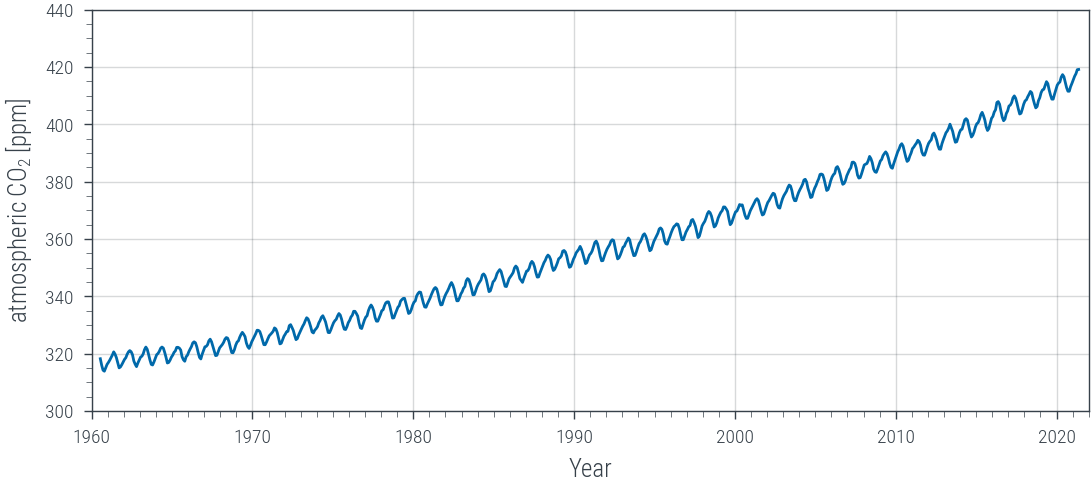

In [18]:
setup_plot(plt.gca())
plot_data(plt.gca())
gp.plot_shaded(
    plt.gca(),
    X,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP prior"},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
    num_samples=5,
    rng_key=jax.random.PRNGKey(3),
)
plt.legend()

Compared to the model from the lecture, it is arguably much more plausible that the data was generated by this model.

### Posterior

In [ ]:
gp_posterior = gp.condition(y_train, X_train, sigma=init_params["sigma"]**2)

plot_data(plt.gca())
gp_posterior.plot_shaded(
    plt.gca(),
    X,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP posterior mean"},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
    num_samples=5,
    rng_key=jax.random.PRNGKey(3),
)
plt.axvline(X_train[-1, 0], color=rgb.tue_gray)

The posterior belief also seems to extrapolate reasonably well.

### Hyperparameter Optimization

In [ ]:
import jaxopt


def NegEvidence(parameters):
    gp = GaussianProcess(
        functools.partial(model_mean, parameters=parameters),
        functools.partial(model_kernel, parameters=parameters),
    )

    noise = Gaussian(
        jnp.zeros_like(y_train),
        parameters["sigma"]**2 * jnp.eye(y_train.size),
    )

    predictive = gp(X_train) + noise

    return -predictive.log_pdf(y_train)

print(NegEvidence(init_params))

optim = jaxopt.ScipyMinimize(
    fun=jax.value_and_grad(NegEvidence),
    method="CG",
    value_and_grad=True,
    maxiter=100,
    jit=True,
    options={"disp": True},
)

opt_params, _ = optim.run(init_params)

In [ ]:
init_params

In [ ]:
opt_params

In [ ]:
gp = GaussianProcess(
    functools.partial(model_mean, parameters=opt_params),
    functools.partial(model_kernel, parameters=opt_params),
)

In [ ]:
gp_posterior = gp.condition(y_train, X_train, sigma=opt_params["sigma"]**2)

plot_data(plt.gca())
gp_posterior.plot_shaded(
    plt.gca(),
    X,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP posterior mean"},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
    num_samples=5,
    rng_key=jax.random.PRNGKey(3),
)
plt.legend()

### Source Separation

**Task:** Visualize the individual posterior belief over all additive components ($f_\text{const}$, $f_\text{GDP}$, $f_\text{periodic}$, $f_\text{mid-term}$, $f_\text{weather}$) using source separation.

In [ ]:
def plot_component(ax, gp_component: GaussianProcess, component_label: str):
    setup_plot(ax)
    ax.set_ylabel("atmospheric CO$_2$ $\Delta$ [ppm]")
    gp_component.plot_shaded(
        ax,
        X,
        yres=1000,
        color=rgb.tue_red,
        mean_kwargs={"label": component_label},
        std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
        num_samples=5,
        rng_key=jax.random.PRNGKey(3),
    )
    ax.axvline(X_train[-1, 0], color=rgb.tue_gray)

In [ ]:
gp_constant =  # TODO

plot_component(plt.gca(), gp_constant, "$f_\mathrm{const}$")
plt.legend()

**Task:** Plot the posterior belief over
\begin{equation*}
    \tilde{g}_\text{GDP}(t, \text{GDP}(t)) := \text{GDP}(t) \cdot g_\text{GDP}(t)
\end{equation*}
using source separation.

In [ ]:
gp_g_tilde =  # TODO

plot_component(plt.gca(), gp_g_tilde, r"$\tilde{g}_\mathrm{GDP}$")
plt.legend()

### Discussion

Interpret the results. Is this a good model of the data? What could be improved and how?

If there is enough time in the tutorial, we'll discuss your thoughts.